In [486]:
# import necessary libraries
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
import os

In [487]:
# set batch size and image size to 32 for quick training
batch_size = 32
img_size = 32
data_dir = 'dataset/' # our directory containing our image dataset

# Apply the transformations
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])

# Load the dataset from 
met_data = datasets.ImageFolder(data_dir, transform=transform)

# Load the met data into a dataloader
met_img_loader = torch.utils.data.DataLoader(met_data, batch_size, shuffle=True)

In [488]:
# scales image pixel values between -1 and 1
def scale(img, feature_range=(-1, 1)):
    min_, max_ = feature_range
    img = img * (max_ - min_) + min_
    return img

In [489]:
# helper conv function, creates a convolutional layer for the Discriminator
def conv(input_channels, output_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=False)
    
    # Adding the created convolutional layer
    layers.append(conv_layer)
    
    # Apply batch normalization if necessary
    if batch_norm:
        layers.append(nn.BatchNorm2d(output_channels))
        
    # returning the sequential container
    return nn.Sequential(*layers)

In [490]:
# Discriminator Class
class Discriminator(nn.Module):

    # initialize Discriminator with given dimension
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        # adds 4 layers using the conv function
        self.cv1 = conv(3, self.conv_dim, 4, batch_norm=False)
        self.cv2 = conv(self.conv_dim, self.conv_dim * 2, 4, batch_norm=True)
        self.cv3 = conv(self.conv_dim * 2, self.conv_dim * 4, 4, batch_norm=True)
        self.cv4 = conv(self.conv_dim * 4, self.conv_dim * 8, 4, batch_norm=True)
        # Fully connected Layer
        self.fc1 = nn.Linear(self.conv_dim * 8 * 2 * 2, 1)

    def forward(self, x):
        # After passing through each layer
        # Applying leaky relu activation function
        x = F.leaky_relu(self.cv1(x), 0.2)
        x = F.leaky_relu(self.cv2(x), 0.2)
        x = F.leaky_relu(self.cv3(x), 0.2)
        x = F.leaky_relu(self.cv4(x), 0.2)
        # To pass throught he fully connected layer
        # We need to flatten the image first
        x = x.view(-1, self.conv_dim * 8 * 2 * 2)
        # Now passing through fully-connected layer
        x = self.fc1(x)
        return x

In [491]:
# Generator helper deconv function, creates a deconvolution layer
def deconv(input_channels, output_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers = []
    convt_layer = nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias=False)

    # Appending the deconvolution layer created
    layers.append(convt_layer)

    if batch_norm:
        # Apply batch normalization if necessary
        layers.append(nn.BatchNorm2d(output_channels))

    # Returning the sequential container
    return nn.Sequential(*layers)

In [492]:
# Generator Class
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        self.z_size = z_size

        self.conv_dim = conv_dim

        # fully-connected-layer
        self.fc = nn.Linear(z_size, self.conv_dim * 8 * 2 * 2)
        # Adds 4 deconvolution layers with deconv helper function
        self.dcv1 = deconv(self.conv_dim * 8, self.conv_dim * 4, 4, batch_norm=True)
        self.dcv2 = deconv(self.conv_dim * 4, self.conv_dim * 2, 4, batch_norm=True)
        self.dcv3 = deconv(self.conv_dim * 2, self.conv_dim, 4, batch_norm=True)
        self.dcv4 = deconv(self.conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        # Passing through fully connected layer
        x = self.fc(x)
        # Changing the dimension
        x = x.view(-1, self.conv_dim * 8, 2, 2)
        
        # Passing through deconv layers
        # Applying the ReLu activation function
        x = F.relu(self.dcv1(x))
        x = F.relu(self.dcv2(x))
        x = F.relu(self.dcv3(x))
        x = torch.tanh(self.dcv4(x))
        # returning the modified image
        return x

In [493]:
# initialize weights to help model converge more quickly
def weights_init_normal(m):
    
    classname = m.__class__.__name__
    
    # For the linear layers
    if 'Linear' in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        m.bias.data.fill_(0.01)
        
    # For the convolutional layers
    if 'Conv' in classname or 'BatchNorm2d' in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

In [494]:
# Setting dimensions for the Discriminator and Generator
d_conv_dim = 32
g_conv_dim = 32

# set size of noise vector
z_size = 100  

# initialize the Discriminator and Generator with given dimension sizes
D = Discriminator(d_conv_dim)
G = Generator(z_size=z_size, conv_dim=g_conv_dim)

# Applying the weight initialization
D.apply(weights_init_normal)
G.apply(weights_init_normal)

print(D)
print(G)

Discriminator(
  (cv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (cv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=1024, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (dcv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): B

In [495]:
# Calculates the real loss
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

# Calculates the fake loss
def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [496]:
# Set hyperparameters for our optimizers
lr = 0.0002
beta1 = 0.3
beta2 = 0.999

# Using Adam optimizer with the given hyperparameters to help train the networks
d_optimizer = optim.Adam(D.parameters(), lr, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr, betas=(beta1, beta2))

In [497]:
# trains the Discriminator and Generator for the given number of epochs
def train(D, G, n_epochs, print_every=100):
    #  param, D: the discriminator network
    # param, G: the generator network
    #  param, n_epochs: number of epochs to train for
    # param, print_every: when to print and record the models' losses
    # return: D and G losses

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 32
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()

            # real images
            real_images = real_images.to(device)
            # create Discriminator with real images
            dreal = D(real_images)
            dreal_loss = real_loss(dreal)


            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            z = z.to(device)
            fake_images = G(z)

            # loss of fake images
            dfake = D(fake_images)
            dfake_loss = fake_loss(dfake)

            # Adding both lossess
            d_loss = dreal_loss + dfake_loss
            # Backpropogation step
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with adversarial loss
            g_optimizer.zero_grad()

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            z = z.to(device)
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake, True)  # use real loss to flip labels

            # perform backpropagation
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch + 1, n_epochs, d_loss.item(), g_loss.item()))

        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval()  # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()  # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

In [498]:
# set number of epochs
n_epochs = 100

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.3854 | g_loss: 0.6895
Epoch [    2/  100] | d_loss: 0.9854 | g_loss: 0.8990
Epoch [    3/  100] | d_loss: 0.6589 | g_loss: 1.1749
Epoch [    4/  100] | d_loss: 0.4063 | g_loss: 1.5442
Epoch [    5/  100] | d_loss: 0.2543 | g_loss: 1.9346
Epoch [    6/  100] | d_loss: 0.1763 | g_loss: 2.2577
Epoch [    7/  100] | d_loss: 0.1321 | g_loss: 2.5803
Epoch [    8/  100] | d_loss: 0.1016 | g_loss: 2.7723
Epoch [    9/  100] | d_loss: 0.1182 | g_loss: 2.7764
Epoch [   10/  100] | d_loss: 0.1007 | g_loss: 2.9637
Epoch [   11/  100] | d_loss: 0.1245 | g_loss: 3.3003
Epoch [   12/  100] | d_loss: 1.4857 | g_loss: 2.2531
Epoch [   13/  100] | d_loss: 0.1183 | g_loss: 3.0855
Epoch [   14/  100] | d_loss: 0.5152 | g_loss: 1.8871
Epoch [   15/  100] | d_loss: 0.7008 | g_loss: 1.6911
Epoch [   16/  100] | d_loss: 0.6697 | g_loss: 3.1662
Epoch [   17/  100] | d_loss: 1.4988 | g_loss: 0.8689
Epoch [   18/  100] | d_loss: 0.5247 | g_loss: 1.8698
Epoch [   19/  100] | d_loss

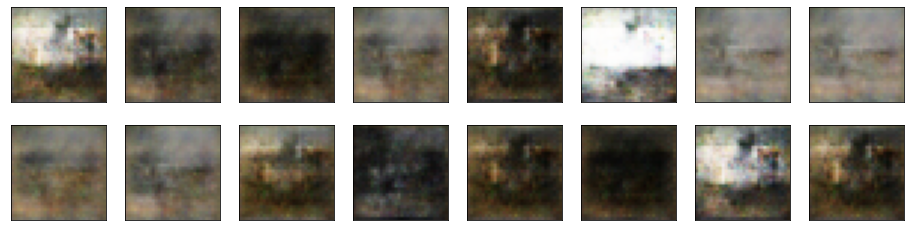

In [504]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1) * 255 / 2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img.reshape((32,32,3)))

# open generated images stored in the pickle file
with open('train_samples_500_beta1=0.3.pkl', 'rb') as f:
    samples = pkl.load(f)
    
# change the '-1' to another epoch number to see the generated images from other epochs!
view_samples(421, samples)